# Simplified deconvolution example

In the referenced article the visualisation is created by 'inverting' the forward steps (calculations performed by the layers) and showing what the activation of these layers means in the input space. This sounds much like calculating a gradient, and indeed after checking several sources, I came to the conclusion that this inversion of the convolution, max pooling and Relu steps is exactly the gradient of these operations w.r.t. the input space.

In order to make sure that this understanding is correct and the gradient operations do indeed give the expected result, I first created this notebook using a minimal toy example so I could manually verify that the results make sense.

I created a `9*9` image with a single horizontal line in row 4, and used a `3*3` vertical Sobel operator as the kernel for the convolution, which performs edge detection. For the sake of simplicity I used only a single kernel (one filter in the layer) and a single channel (grayscale) image.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_cnnvis
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def norm_image(image, ubound = 255.0):
    img_min = np.min(image)
    img_max = np.max(image)
    return (((image - img_min) * ubound) / (img_max - img_min)).astype('uint8')

# Initialise the variables

In [164]:
img_size = 9 # image used for testing
w_size = 3 # size of the convolution kernel

img_shape = [1, img_size, img_size, 1]
w_shape = [w_size, w_size, 1, 1]

img_val_np = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0]] * 9).T
img_val = np.reshape(img_val_np, [1, 9, 9, 1])

w_np = np.array([[-1.0, -2.0, -1.0], [0., 0., 0.], [1., 2., 1.]])

# The scope is required so AUTO_REUSE can be set, which is needed to enable re-running 
# the cell without changing the name of the variable
with tf.variable_scope('simple_convolution', reuse=tf.AUTO_REUSE) as scope:
    w = tf.get_variable("kernel", dtype=tf.float32, 
      initializer=tf.cast(np.reshape(w_np, w_shape), tf.float32))

    img = tf.placeholder("float", [None, 9, 9, 1])

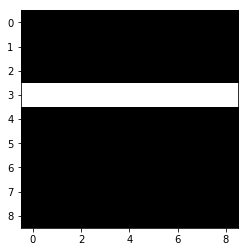

In [165]:
plt.imshow(img_val_np, interpolation="nearest", cmap="gray")

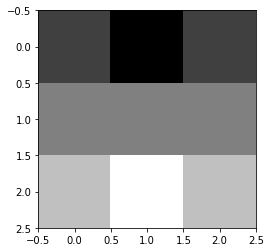

In [166]:
plt.imshow(w_np, interpolation="nearest", cmap="gray")

# Perform the convolution (forward step)

In [167]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv1 = tf.nn.conv2d(img, w, [1, 1, 1, 1], "SAME", name="conv1")
    conv1_val = sess.run(conv1, feed_dict={img: img_val})
conv1_val.squeeze()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-3., -4., -4., -4., -4., -4., -4., -4., -3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

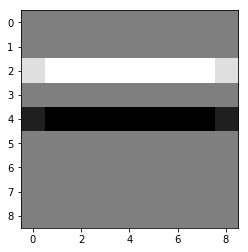

In [168]:
plt.imshow(norm_image(conv1_val.squeeze()), interpolation="nearest", cmap="gray")

As expected, the result of a convolution are two non-zero lines, showing the positive and negative gradient of the edge.

Note the slightly different values in the first and last columns, which is the result of the `padding="SAME"` setting.

# Backward step of convolution - using the transpose convolution method

In [169]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    d_conv1_img_trans = tf.nn.conv2d_transpose(conv1, w, [1, 9, 9, 1], [1, 1, 1, 1], "SAME")[0]
    d_conv1_img_trans_val = sess.run(d_conv1_img_trans, feed_dict={img: img_val})
d_conv1_img_trans_val.squeeze()

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-10., -15., -16., -16., -16., -16., -16., -15., -10.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 20.,  30.,  32.,  32.,  32.,  32.,  32.,  30.,  20.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-10., -15., -16., -16., -16., -16., -16., -15., -10.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

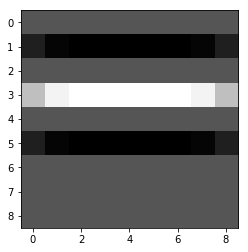

In [170]:
plt.imshow(norm_image(d_conv1_img_trans_val.squeeze()), interpolation="nearest", cmap="gray")

This is the method described in the article. Tensorflow has a built-in operation called `conv2d_transpose`, so there is no need to manually flip the weights of the kernel.

As expected, the positive edge at row 3 was correctly reconstructed. 

Note that there was no non-linearity applied to the convolution at this stage, so the result also includes negative numbers. This is because, despite the confusing naming used in recent computer vision/deep learning literature, the transpose of the convolution is not actually a deconvolution.

# Backward step of convolution - calculating the gradient

In [127]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    d_conv1_img_grad = tf.gradients(conv1, img)[0]
    d_conv1_img_grad_val = sess.run(d_conv1_img_grad, feed_dict={img: img_val})
d_conv1_img_grad_val.squeeze()

array([[-3., -4., -4., -4., -4., -4., -4., -4., -3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.]], dtype=float32)

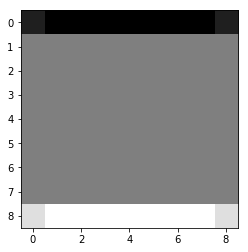

In [128]:
plt.imshow(norm_image(d_conv1_img_grad_val.squeeze()), interpolation="nearest", cmap="gray")

Multiple sources state the the transpose of the convolution equals to the gradient of it, so I wanted to verify this expecting the same output as in the previous section. As you can see on this image, the results are not at all the same – this is actually uniformly 0, except the top and bottom rows of the image, where the values are caused by the padding, not any real image features.

I was puzzled by this, as I was pretty certain this should make sense and this was only supposed to be a quick sanity check. I would never admit how much time I have spent on trying to figure out what went wrong here, reading several other articles on de/convolution, the documentation and source code of Tensorflow, related answers on StackOverflow, etc. (Can you spot the error right away?)

The problem here is that due to the choice of the input image/kernel, the sum/average of the values returned by the convolution is exactly 0, so the gradient is 0 as well, so the gradient w.r.t. the input is also uniformly 0. This is caused by the simple fact that I (intentionally) did not include a non-linearity to keep the example minimal, but I also failed to provide a gradient which would return a non-zero value. I did not find anyone having the same problem simply because no one was using convolutions without a non-linearity, and with a perfectly symmetrical output.. After realising this, I could easily correct it by adding the `tf.reduce_max` operation to the graph, which resulted in a non-zero gradient and the expected output.

In [171]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    d_conv1_img_grad = tf.gradients(tf.reduce_max(conv1), img)[0] # Notice the reduce_max added to the graph
    d_conv1_img_grad_val = sess.run(d_conv1_img_grad, feed_dict={img: img_val})
d_conv1_img_grad_val.squeeze()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.14285715, -0.42857146, -0.5714286 , -0.5714286 , -0.5714286 ,
        -0.5714286 , -0.5714286 , -0.42857146, -0.14285715],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14285715,  0.42857146,  0.5714286 ,  0.5714286 ,  0.5714286 ,
         0.5714286 ,  0.5714286 ,  0.42857146,  0.14285715],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

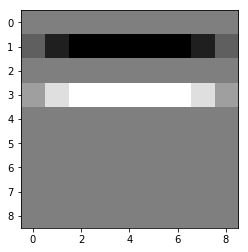

In [172]:
plt.imshow(norm_image(d_conv1_img_grad_val.squeeze()), interpolation="nearest", cmap="gray")

# Max pooling

The original article describes a cumbersome method of storing each pixel that was selected in a max pooling operation, and in reverse mode activating only that pixel. Tensorflow has something similar implemented under the name `tf.nn.max_pool_with_argmax`, however this opration sounds just like the gradient of a max pool layer. Let's verify that calculating the gradient is equivalent to this operation. Here I used an image of random pixels instead of the previous one, as max pooling does not make much sense if all the pixels have only two distinct values.

In [133]:
img_rnd_val = np.random.randint(255, size=[1, 9, 9, 1])
img_rnd_val.shape

(1, 9, 9, 1)

In [150]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    mp = tf.nn.max_pool(img, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')[0]
    d_mp = tf.gradients(mp, img)[0]
    mp_val, d_mp_val = sess.run([mp, d_mp], feed_dict={img: img_rnd_val})
mp_val.squeeze()

array([[ 234.,  246.,  204.,  238.,  239.],
       [ 220.,  218.,  219.,  246.,   79.],
       [ 158.,  233.,  249.,  202.,  189.],
       [ 218.,  168.,  182.,  179.,  232.],
       [ 165.,  113.,   97.,  175.,  241.]], dtype=float32)

In [151]:
d_mp_val.squeeze()

array([[ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.]], dtype=float32)

In [152]:
img_rnd_val.squeeze()

array([[184, 152,  78, 246, 204, 138, 238, 182, 239],
       [234, 143, 185, 154,  17, 150, 107, 104,  63],
       [220, 112, 112, 108,  96, 150,  66, 246,  79],
       [220,  59, 218,  65, 219, 184,  80, 125,  46],
       [ 89,  85, 185, 192, 249,  73, 199,  90,  88],
       [ 35, 158,  35, 233, 167,   2, 112, 202, 189],
       [175, 193, 151, 168, 116,  92, 118,  60,  69],
       [ 59, 218,  78,  57, 112, 182,  98, 179, 232],
       [165,  17,  92, 113,  22,  97,  52, 175, 241]])

In [163]:
is_ok = True
for i in range(0, img_rnd_val.shape[1], 2): # Iterate over the input image/output gradient in 2x2 blocks
    for j in range(0, img_rnd_val.shape[2], 2):
        values = img_rnd_val[0, i:i+2, j:j+2, 0] # Get the 4 values of the image in this 2x2 block
        masked_values = (img_rnd_val[0, i:i+2, j:j+2, 0] 
                         * d_mp_val[0, i:i+2, j:j+2, 0]) # Get of the original image where the gradient has a value of 1
        if np.max(values) != np.max(masked_values): # If the gradient points to the correct pixel then selecting 
                                                    # the max of the previous two 2x2 matrices should yield the same value
            is_ok = False
            print("The resulting gradient did not select the max values for {}:{}".format(i, j))
            break
if is_ok:
    print("The gradient calculation is correct.")

The gradient calculation is correct


Having checked that calculating the gradient w.r.t. the input gives the result we expect for the visualisation, let's move on to actually solving the task at hand.